In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import xarray as xr
import tqdm
import joblib
import utils as utils
import cartopy.crs as ccrs
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_spatial_GP as plaingp
import src.evaluation.visualisation as vis
from src.models.utils_spatial import compute_means

<IPython.core.display.Javascript object>

In [3]:
def encapsulate_as_xarray(data, scenario):
    field = xr.DataArray(data=data.cpu(),
                         dims=['time', 'lat', 'lon'],
                         coords=dict(time=scenario.timesteps.cpu(),
                                     lat=scenario.lat.cpu(),
                                     lon=scenario.lon.cpu()))
    return field

def weighted_mean(x, wlat):
    mu = torch.sum(x * wlat, dim=(1, 2)) / (x.size(2) * wlat.sum())
    return mu

## SSP245

In [4]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp370', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp245']}}
test_data = plaingp.make_data(test_cfg)
test_tas = test_data.scenarios.tas

encapsulate = lambda data: encapsulate_as_xarray(data, test_data.scenarios[0])

In [5]:
scenarios = train_data.scenarios
all_tas = scenarios.tas
wlat = torch.cos(torch.deg2rad(scenarios[0].lat)).clip(min=torch.finfo(torch.float64).eps)[:, None]
glob_tas = weighted_mean(all_tas, wlat)

pattern_scaling = LinearRegression()
pattern_scaling.fit(glob_tas[:, None], all_tas.reshape(all_tas.size(0), -1))

LinearRegression()

In [6]:
time_slice = slice(-21, None)

pred = compute_means(test_data.scenarios, pattern_scaling)['ssp245']
xr_pred = encapsulate(pred)
xr_groundtruth = encapsulate(test_tas)

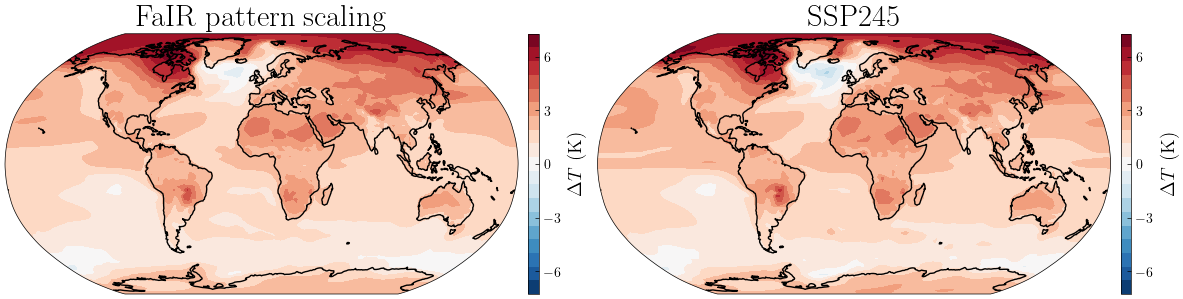

In [7]:
start, end = 2080, 2100
time_slice = slice(start, end)

xr_pred_plot = xr_pred.sel(time=time_slice).mean(dim='time')
xr_groundtruth_plot = xr_groundtruth.sel(time=time_slice).mean(dim='time')
vmax = max(xr_pred_plot.max().values.item(), xr_groundtruth_plot.max().values.item())

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.Robinson()})

fig, _, cbar = vis.plot_contourf_on_ax(xr_pred.sel(time=time_slice).mean(dim='time'),
                                       fig, ax[0], colorbar=True, vmax=vmax)
cbar.set_ticks([-6, -3, 0, 3, 6])

fig, _, cbar = vis.plot_contourf_on_ax(xr_groundtruth.sel(time=time_slice).mean(dim='time'),
                                       fig, ax[1], colorbar=True, vmax=vmax)
cbar.set_ticks([-6, -3, 0, 3, 6])

ax[0].set_title("FaIR pattern scaling", fontsize=22)
ax[1].set_title("SSP245", fontsize=22)

plt.tight_layout()
# plt.savefig('./figures/SSP245-spatial-prediction-FaIR-pattern-scaling.png', dpi=200)
plt.show()

In [8]:
# Compute mean bias
mean_bias = pred - test_tas
xr_bias = encapsulate(mean_bias).sel(time=time_slice)

# Run t-test to identify insignificant differences
slice_posterior_mean = xr_pred.sel(time=time_slice).values.reshape(21, -1)
slice_groundtruth = xr_groundtruth.sel(time=time_slice).values.reshape(21, -1)
pvalues = ttest_ind(slice_posterior_mean, slice_groundtruth).pvalue
insignificant = (pvalues < 0.05).astype(int).reshape(96, 144)
xr_insignificant = xr.DataArray(data=insignificant,
                         dims=['lat', 'lon'],
                         coords=dict(lat=xr_bias.lat,
                                     lon=xr_bias.lon))

# Set to zero insignificant biases
xr_bias = xr_bias * xr_insignificant

# Save bias xarray
# xr_bias.to_netcdf('./netcdf/bias-ssp245-FaIR-pattern-scaling.nc')

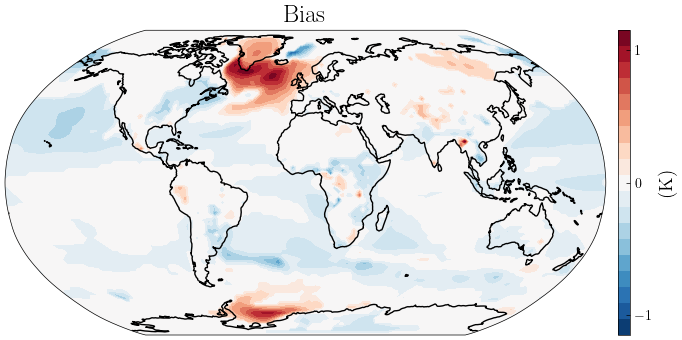

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6), subplot_kw={'projection': ccrs.Robinson()})

idx = 35

_, __, cbar = vis.plot_contourf_on_ax(xr_bias.sel(time=time_slice).mean(dim='time'), 
                                      fig, ax, colorbar=True)
cbar.set_label('(K)', fontsize=14)
cbar.set_ticks([-1, 0, 1])

ax.set_title("Bias", fontsize=18)

plt.tight_layout()

# plt.savefig('./figures/SSP245-spatial-FaIR-pattern-scaling.png', dpi=200)
plt.show()

## SSP126

In [10]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp245', 'ssp370', 'ssp585']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp126']}}
test_data = plaingp.make_data(test_cfg)
test_tas = test_data.scenarios.tas

encapsulate = lambda data: encapsulate_as_xarray(data, test_data.scenarios[0])

In [11]:
scenarios = train_data.scenarios
all_tas = scenarios.tas
wlat = torch.cos(torch.deg2rad(scenarios[0].lat)).clip(min=torch.finfo(torch.float64).eps)[:, None]
glob_tas = weighted_mean(all_tas, wlat)

pattern_scaling = LinearRegression()
pattern_scaling.fit(glob_tas[:, None], all_tas.reshape(all_tas.size(0), -1))

LinearRegression()

In [12]:
time_slice = slice(-21, None)

pred = compute_means(test_data.scenarios, pattern_scaling)['ssp126']
xr_pred = encapsulate(pred)
xr_groundtruth = encapsulate(test_tas)

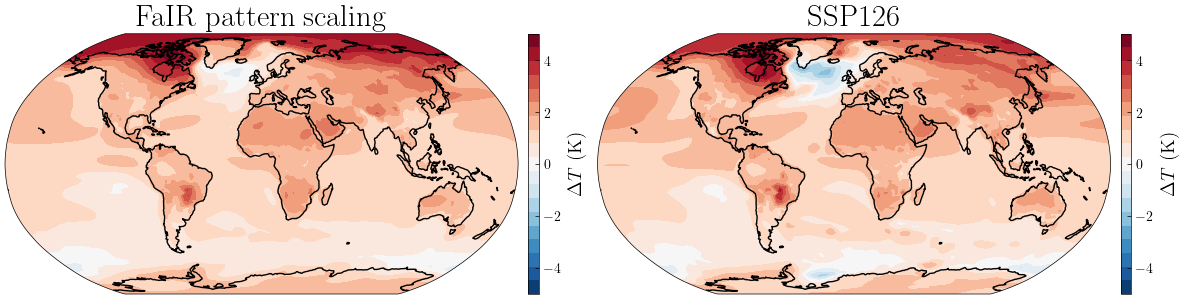

In [13]:
start, end = 2080, 2100
time_slice = slice(start, end)

xr_pred_plot = xr_pred.sel(time=time_slice).mean(dim='time')
xr_groundtruth_plot = xr_groundtruth.sel(time=time_slice).mean(dim='time')
vmax = max(xr_pred_plot.max().values.item(), xr_groundtruth_plot.max().values.item())

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.Robinson()})

fig, _, cbar = vis.plot_contourf_on_ax(xr_pred.sel(time=time_slice).mean(dim='time'),
                                       fig, ax[0], colorbar=True, vmax=vmax)
cbar.set_ticks([-4, -2, 0, 2, 4])

fig, _, cbar = vis.plot_contourf_on_ax(xr_groundtruth.sel(time=time_slice).mean(dim='time'),
                                       fig, ax[1], colorbar=True, vmax=vmax)
cbar.set_ticks([-4, -2, 0, 2, 4])

ax[0].set_title("FaIR pattern scaling", fontsize=22)
ax[1].set_title("SSP126", fontsize=22)

plt.tight_layout()
# plt.savefig('./figures/SSP126-spatial-prediction-FaIR-pattern-scaling.png', dpi=200)
plt.show()

In [14]:
# Compute mean bias
mean_bias = pred - test_tas
xr_bias = encapsulate(mean_bias).sel(time=time_slice)

# Run t-test to identify insignificant differences
slice_posterior_mean = xr_pred.sel(time=time_slice).values.reshape(21, -1)
slice_groundtruth = xr_groundtruth.sel(time=time_slice).values.reshape(21, -1)
pvalues = ttest_ind(slice_posterior_mean, slice_groundtruth).pvalue
insignificant = (pvalues < 0.05).astype(int).reshape(96, 144)
xr_insignificant = xr.DataArray(data=insignificant,
                         dims=['lat', 'lon'],
                         coords=dict(lat=xr_bias.lat,
                                     lon=xr_bias.lon))

# Set to zero insignificant biases
xr_bias = xr_bias * xr_insignificant

# Save bias xarray
# xr_bias.to_netcdf('./netcdf/bias-ssp126-FaIR-pattern-scaling.nc')

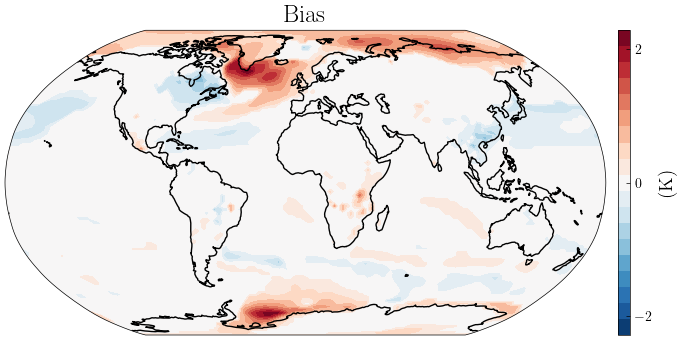

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6), subplot_kw={'projection': ccrs.Robinson()})

idx = 35

_, __, cbar = vis.plot_contourf_on_ax(xr_bias.sel(time=time_slice).mean(dim='time'), 
                                      fig, ax, colorbar=True)
cbar.set_label('(K)', fontsize=14)
cbar.set_ticks([-2, 0, 2])

ax.set_title("Bias", fontsize=18)

plt.tight_layout()

# plt.savefig('./figures/SSP126-spatial-FaIR-pattern-scaling.png', dpi=200)
plt.show()

## SSP585

In [17]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp370']}}
train_data = plaingp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp585']}}
test_data = plaingp.make_data(test_cfg)
test_tas = test_data.scenarios.tas

encapsulate = lambda data: encapsulate_as_xarray(data, test_data.scenarios[0])

In [18]:
scenarios = train_data.scenarios
all_tas = scenarios.tas
wlat = torch.cos(torch.deg2rad(scenarios[0].lat)).clip(min=torch.finfo(torch.float64).eps)[:, None]
glob_tas = weighted_mean(all_tas, wlat)

pattern_scaling = LinearRegression()
pattern_scaling.fit(glob_tas[:, None], all_tas.reshape(all_tas.size(0), -1))

LinearRegression()

In [19]:
time_slice = slice(-21, None)

pred = compute_means(test_data.scenarios, pattern_scaling)['ssp585']
xr_pred = encapsulate(pred)
xr_groundtruth = encapsulate(test_tas)

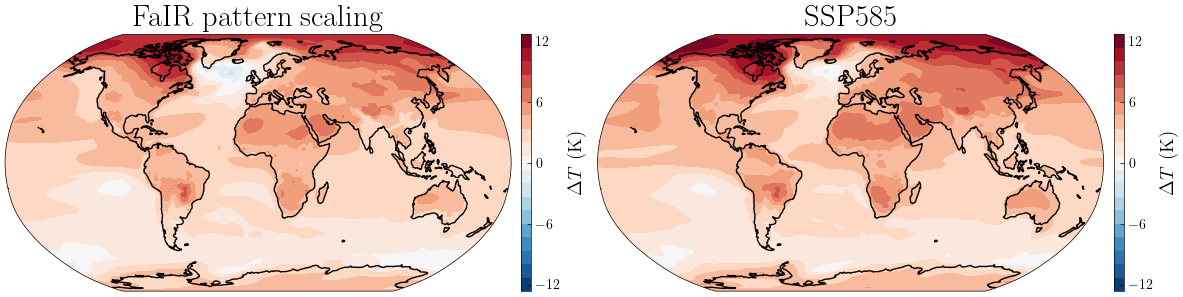

In [20]:
start, end = 2080, 2100
time_slice = slice(start, end)

xr_pred_plot = xr_pred.sel(time=time_slice).mean(dim='time')
xr_groundtruth_plot = xr_groundtruth.sel(time=time_slice).mean(dim='time')
vmax = max(xr_pred_plot.max().values.item(), xr_groundtruth_plot.max().values.item())

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.Robinson()})

fig, _, cbar = vis.plot_contourf_on_ax(xr_pred.sel(time=time_slice).mean(dim='time'),
                                       fig, ax[0], colorbar=True, vmax=vmax)
cbar.set_ticks([-12, -6, 0, 6, 12])

fig, _, cbar = vis.plot_contourf_on_ax(xr_groundtruth.sel(time=time_slice).mean(dim='time'),
                                       fig, ax[1], colorbar=True, vmax=vmax)
cbar.set_ticks([-12, -6, 0, 6, 12])

ax[0].set_title("FaIR pattern scaling", fontsize=22)
ax[1].set_title("SSP585", fontsize=22)

plt.tight_layout()
# plt.savefig('./figures/SSP585-spatial-prediction-FaIR-pattern-scaling.png', dpi=200)
plt.show()

In [21]:
# Compute mean bias
mean_bias = pred - test_tas
xr_bias = encapsulate(mean_bias).sel(time=time_slice)

# Run t-test to identify insignificant differences
slice_posterior_mean = xr_pred.sel(time=time_slice).values.reshape(21, -1)
slice_groundtruth = xr_groundtruth.sel(time=time_slice).values.reshape(21, -1)
pvalues = ttest_ind(slice_posterior_mean, slice_groundtruth).pvalue
insignificant = (pvalues < 0.05).astype(int).reshape(96, 144)
xr_insignificant = xr.DataArray(data=insignificant,
                         dims=['lat', 'lon'],
                         coords=dict(lat=xr_bias.lat,
                                     lon=xr_bias.lon))

# Set to zero insignificant biases
xr_bias = xr_bias * xr_insignificant

# Save bias xarray
# xr_bias.to_netcdf('./netcdf/bias-ssp585-FaIR-pattern-scaling.nc')

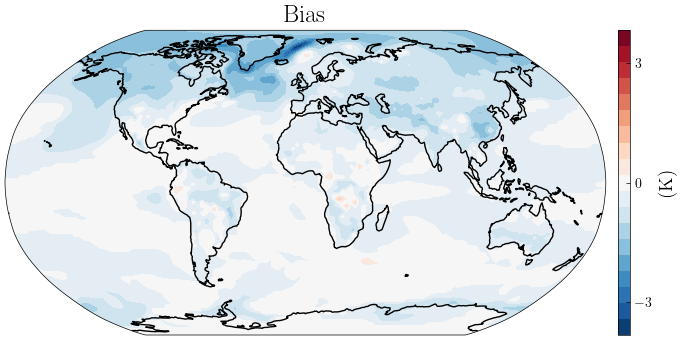

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6), subplot_kw={'projection': ccrs.Robinson()})

idx = 35

_, __, cbar = vis.plot_contourf_on_ax(xr_bias.sel(time=time_slice).mean(dim='time'), 
                                      fig, ax, colorbar=True)
cbar.set_label('(K)', fontsize=14)
cbar.set_ticks([-3, 0, 3])

ax.set_title("Bias", fontsize=18)

plt.tight_layout()

# plt.savefig('./figures/SSP585-spatial-FaIR-pattern-scaling.png', dpi=200)
plt.show()